In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

%aimport CTR_Dominating_Stiffness
from CTR_Dominating_Stiffness import CTR_DomStiff
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

(2, 100)
(2, 100)


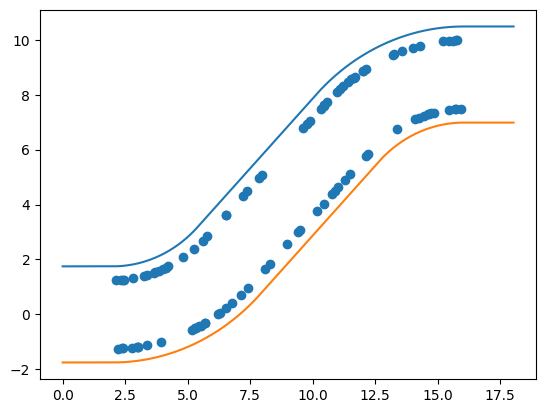

In [68]:
tube_diameter = 3.5 # diameter of tube (cm)
tube_radius_of_curvature = 6.5 # radius of curvature of tube (cm)
tube_curve_length = 5.16 # length of curved section of tube in middle (cm)
middle_length = 6.8 # length of middle section of tube (cm)
end_lengths = 2.0 # length of straight sections at ends of tube (cm)

class Pipe_Workspace:
    def __init__(self, diameter, radius_of_curvature, curve_length, middle_length, end_lengths):
        self.diameter = diameter
        self.radius_of_curvature = radius_of_curvature
        self.curve_length = curve_length
        self.middle_length = middle_length
        self.end_lengths = end_lengths
        self.theta = curve_length / radius_of_curvature
        self.x_final = 2*end_lengths + 2*radius_of_curvature*np.sin(self.theta) + middle_length*np.cos(self.theta)
        
    def get_tube_bounds(self, x):
        r_large = self.radius_of_curvature + self.diameter/2
        r_small = self.radius_of_curvature - self.diameter/2

        upper_x = [0]
        upper_x.append(self.end_lengths)
        upper_x.append(self.end_lengths + r_small*np.sin(self.theta))
        upper_x.append(self.end_lengths + r_small*np.sin(self.theta) + self.middle_length*np.cos(self.theta))
        upper_x.append(self.x_final - self.end_lengths)
        lower_x = [0]
        lower_x.append(self.end_lengths)
        lower_x.append(self.end_lengths + r_large*np.sin(self.theta))
        lower_x.append(self.end_lengths + r_large*np.sin(self.theta) + self.middle_length*np.cos(self.theta))
        lower_x.append(self.x_final - self.end_lengths)

        conditions = []
        upper = []
        lower = []
        
        upper.append(self.diameter/2)
        upper.append(lambda x: -np.sqrt(r_small**2 - (x - self.end_lengths)**2) + self.radius_of_curvature)
        upper.append(lambda x: np.tan(self.theta)*(x - upper_x[2]) + r_small*(1-np.cos(self.theta)) + self.diameter/2)
        upper.append(lambda x: np.sqrt(r_large**2 - (x - upper_x[4])**2) - self.radius_of_curvature + 2*self.radius_of_curvature*(1-np.cos(self.theta)) + self.middle_length*np.sin(self.theta))
        upper.append(2*self.radius_of_curvature*(1-np.cos(self.theta)) + self.middle_length*np.sin(self.theta) + self.diameter/2)
        lower.append(-self.diameter/2)
        lower.append(lambda x: -np.sqrt(r_large**2 - (x - self.end_lengths)**2) + self.radius_of_curvature)
        lower.append(lambda x: np.tan(self.theta)*(x - lower_x[2]) + r_large*(1-np.cos(self.theta)) - self.diameter/2)
        lower.append(lambda x: np.sqrt(r_small**2 - (x - lower_x[4])**2) - self.radius_of_curvature + 2*self.radius_of_curvature*(1-np.cos(self.theta)) + self.middle_length*np.sin(self.theta))
        lower.append(2*self.radius_of_curvature*(1-np.cos(self.theta)) + self.middle_length*np.sin(self.theta) - self.diameter/2)
        
        conditions_list = []
        for changes_x in [upper_x, lower_x]:
            conditions = []
            conditions.append((x <= changes_x[1]))
            conditions.append((x > changes_x[1]) & (x <= changes_x[2]))
            conditions.append((x > changes_x[2]) & (x <= changes_x[3]))
            conditions.append((x > changes_x[3]) & (x <= changes_x[4]))
            conditions.append((x > changes_x[4]))
            conditions_list.append(conditions)
        
        return np.piecewise(x, conditions_list[0], upper), np.piecewise(x, conditions_list[1], lower)
    
    def tube_shape(self, dpts=1000):
        x = np.linspace(0, self.x_final, dpts)
        upper, lower = self.get_tube_bounds(x)
        return x, upper, lower
    
    def get_test_locations(self, num_tests, delta_x=0.01):
        min_focal_length = 0.5
        dx = np.ones(num_tests) * delta_x
        x = np.random.uniform(self.end_lengths, self.x_final - self.end_lengths, num_tests)
        side = np.random.randint(0, 2, num_tests)
        upper, lower = self.get_tube_bounds(x)
        y = np.where(side, upper, lower)
        y2upper, y2lower = self.get_tube_bounds(x + dx)
        dy = np.where(side, y2upper, y2lower) - y
        direction = np.where(side, 1, -1)[np.newaxis,:] * np.vstack([-dy, dx])
        direction /= np.linalg.norm(direction, axis=0)
        coordinates = np.vstack([x, y])
        print(coordinates.shape)
        print(direction.shape)
        coordinates -= min_focal_length * direction
        return coordinates, direction
    
Pipe = Pipe_Workspace(tube_diameter, tube_radius_of_curvature, tube_curve_length, middle_length, end_lengths)
x, upper, lower = Pipe.tube_shape()
test_locs = Pipe.get_test_locations(100)
plt.plot(x, upper)
plt.plot(x, lower)
plt.scatter(test_locs[0][0,:], test_locs[0][1,:])
plt.show()


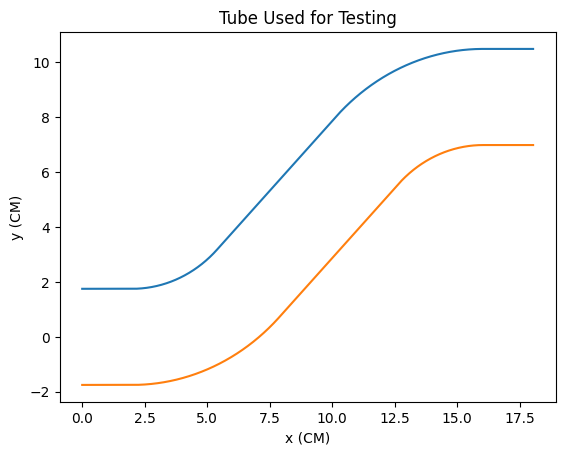

In [3]:
# Adding a pipe profile into the plots

# FROM TYLER
# define the pipe used for testing

tube_diameter = 35 # diameter of tube (mm)
tube_radius_of_curvature = 65 # radius of curvature of tube (mm)
tube_curve_length = 51.6 # length of curved section of tube in middle (mm)
middle_length = 68 # length of middle section of tube (mm)
end_lengths = 20 # length of straight sections at ends of tube (mm)

# define the tube used for testing using a numpy array
def create_tube(diameter, radius_of_curvature, curve_length, middle_length, end_lengths):
    theta = curve_length / radius_of_curvature
    x_final = 2*end_lengths + 2*radius_of_curvature*np.sin(theta) + middle_length*np.cos(theta)
    x = np.linspace(0, x_final, 1000)

    r_large = radius_of_curvature + diameter/2
    r_small = radius_of_curvature - diameter/2

    upper_x = [0]
    upper_x.append(end_lengths)
    upper_x.append(end_lengths + r_small*np.sin(theta))
    upper_x.append(end_lengths + r_small*np.sin(theta) + middle_length*np.cos(theta))
    upper_x.append(x_final - end_lengths)
    lower_x = [0]
    lower_x.append(end_lengths)
    lower_x.append(end_lengths + r_large*np.sin(theta))
    lower_x.append(end_lengths + r_large*np.sin(theta) + middle_length*np.cos(theta))
    lower_x.append(x_final - end_lengths)

    conditions = []
    upper = []
    lower = []
    
    upper.append(diameter/2)
    upper.append(lambda x: -np.sqrt(r_small**2 - (x - end_lengths)**2) + radius_of_curvature)
    upper.append(lambda x: np.tan(theta)*(x - upper_x[2]) + r_small*(1-np.cos(theta)) + diameter/2)
    upper.append(lambda x: np.sqrt(r_large**2 - (x - upper_x[4])**2) - radius_of_curvature + 2*radius_of_curvature*(1-np.cos(theta)) + middle_length*np.sin(theta))
    upper.append(2*radius_of_curvature*(1-np.cos(theta)) + middle_length*np.sin(theta) + diameter/2)
    lower.append(-diameter/2)
    lower.append(lambda x: -np.sqrt(r_large**2 - (x - end_lengths)**2) + radius_of_curvature)
    lower.append(lambda x: np.tan(theta)*(x - lower_x[2]) + r_large*(1-np.cos(theta)) - diameter/2)
    lower.append(lambda x: np.sqrt(r_small**2 - (x - lower_x[4])**2) - radius_of_curvature + 2*radius_of_curvature*(1-np.cos(theta)) + middle_length*np.sin(theta))
    lower.append(2*radius_of_curvature*(1-np.cos(theta)) + middle_length*np.sin(theta) - diameter/2)
    
    conditions_list = []
    for changes_x in [upper_x, lower_x]:
        conditions = []
        conditions.append((x <= changes_x[1]))
        conditions.append((x > changes_x[1]) & (x <= changes_x[2]))
        conditions.append((x > changes_x[2]) & (x <= changes_x[3]))
        conditions.append((x > changes_x[3]) & (x <= changes_x[4]))
        conditions.append((x > changes_x[4]))
        conditions_list.append(conditions)
    
    return x/10, np.piecewise(x, conditions_list[0], upper)/10, np.piecewise(x, conditions_list[1], lower)/10

# print(create_tube(x_vals, tube_diameter, tube_radius_of_curvature, tube_curve_length, middle_length, end_lengths))

# plot the tube used for testing
pipe = create_tube(tube_diameter, tube_radius_of_curvature, tube_curve_length, middle_length, end_lengths)
fig, ax = plt.subplots()
ax.plot(pipe[0], pipe[1])
ax.plot(pipe[0], pipe[2])
ax.set_title('Tube Used for Testing', wrap=True)
ax.set_xlabel('x (CM)')
ax.set_ylabel('y (CM)')
plt.show()

<AxesSubplot: >

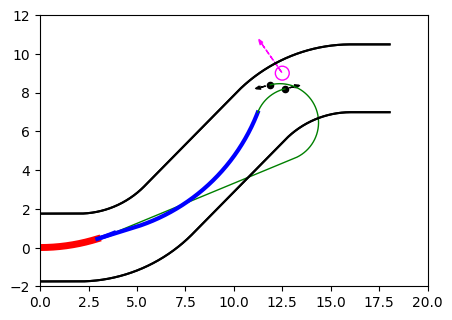

In [26]:
# Define Robot Constants
Lengths = [7,14,20] # --> [L3, L2, L1]
Curved_Lengths = [3,9,6] # --> [L3c, L2c, L1c] (less than or equal to) [L3, L2, L1]
Kappas = np.array([1/10,1/10,1/2]) # --> [k3, k2, k1]
# ^^^-------------- Kappas and Curved_Lengths are the parameters to be optimized by Tyler

# Create a CTR robot object
CTR_robot = CTR_DomStiff(Lengths, Curved_Lengths, Kappas, pipe)

def cost_inv_custom(target_xy, target_dir, tip_xy, normal_dir) -> float:
    return np.linalg.norm(tip_xy-target_xy)**2+ (0.1)*np.linalg.norm(normal_dir-target_dir)**2

# Try to go to the top side of the pipe
target_xy_top = [12.5,9]
target_dir_top = [-0.7,1]
inverse_results_top = CTR_robot.inverse_kin(target_xy_top, target_dir_top, cost_inv_custom)
CTR_robot.plot_inverse(target_xy_top, target_dir_top, inverse_results_top, num_sol_to_plot=2)

<AxesSubplot: >

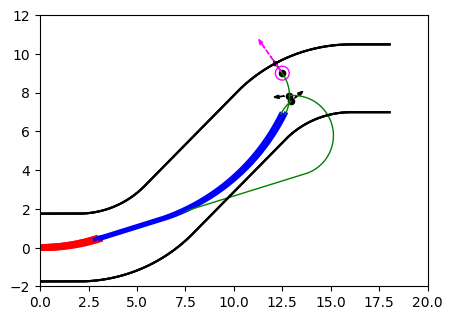

In [29]:
# Define Robot Constants
opt_vals = [2.87974698,  8.64525377,  6.09095807,  0.10461264,  0.09382842,  0.48286981, 6.99615305, 16.18773485, 20.8537647 ]
Lengths = opt_vals[6:9] # --> [L3, L2, L1]
Curved_Lengths = opt_vals[0:3] # --> [L3c, L2c, L1c] (less than or equal to) [L3, L2, L1]
Kappas = opt_vals[3:6] # --> [k3, k2, k1]
# ^^^-------------- Kappas and Curved_Lengths are the parameters to be optimized by Tyler

# Create a CTR robot object
CTR_robot = CTR_DomStiff(Lengths, Curved_Lengths, Kappas, pipe)

# def cost_inv_custom(target_xy, target_dir, tip_xy, normal_dir) -> float:
#     return np.linalg.norm(tip_xy-target_xy)**2+ (0.1)*np.linalg.norm(normal_dir-target_dir)**2

# Try to go to the top side of the pipe
target_xy_top = [12.5,9]
target_dir_top = [-0.7,1]
inverse_results_top = CTR_robot.inverse_kin(target_xy_top, target_dir_top)
CTR_robot.plot_inverse(target_xy_top, target_dir_top, inverse_results_top, num_sol_to_plot=3)